In [1]:
import os

data_dir ='C:\\Users\\Keerthi\\Desktop\\Jigsaw\\10 UC-Advance Analytics & Machine Learning\\02-Assignment\\Final Project\\working'
os.chdir(data_dir)

import pandas as pd
import numpy as np
import re

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
x_train = pd.read_csv('train_new_1.csv')
train=x_train.copy()
print('Shape of the Dataset-->',x_train.shape)
x_train.head()



Shape of the Dataset--> (163010, 9)


,disbursed_amount,ltv,Age,AVERAGE.ACCT.AGE,PERFORM_CNS.SCORE,PRIMARY.INSTAL.AMT,PRI.CURRENT.BALANCE,PRI.NO.OF.ACCTS,NO.OF_INQUIRIES
0,27529,38.42,25,0,0,0,0,0,0
1,46349,73.25,39,18,632,195678,873125,7,0
2,61447,83.29,39,0,0,0,0,0,0
3,55013,84.32,44,19,300,15278,67850,12,0
4,32884,53.25,40,0,0,0,0,0,0


In [3]:
y_train = pd.read_csv('y_train_new_1.csv') 
x_test = pd.read_csv('x_test_new.csv') 
y_test = pd.read_csv('y_test_new.csv') 


In [4]:
loan_test = pd.read_csv('loan_test_new.csv')


In [5]:
print('Shape of the Dataset-->',loan_test.shape)
loan_test.head()

Shape of the Dataset--> (112392, 10)


,UniqueID,disbursed_amount,ltv,Age,AVERAGE.ACCT.AGE,PERFORM_CNS.SCORE,PRIMARY.INSTAL.AMT,PRI.CURRENT.BALANCE,PRI.NO.OF.ACCTS,NO.OF_INQUIRIES
0,655269,53478,86.54,45,0,0,0,0,0,0
1,723482,55513,89.45,34,8,749,5605,43898,2,1
2,758529,65282,79.93,24,0,0,0,0,0,0
3,763449,46905,76.58,46,29,14,0,132480,1,0
4,708663,51428,86.08,47,0,0,0,0,0,0


In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(163010, 9)
(163010, 1)
(69884, 9)
(69884, 1)


# 5 Checking Data type

In [7]:
x_train.dtypes

disbursed_amount         int64
ltv                    float64
Age                      int64
AVERAGE.ACCT.AGE         int64
PERFORM_CNS.SCORE        int64
PRIMARY.INSTAL.AMT       int64
PRI.CURRENT.BALANCE      int64
PRI.NO.OF.ACCTS          int64
NO.OF_INQUIRIES          int64
dtype: object

In [8]:
x_test.dtypes

disbursed_amount         int64
ltv                    float64
Age                      int64
AVERAGE.ACCT.AGE         int64
PERFORM_CNS.SCORE        int64
PRIMARY.INSTAL.AMT       int64
PRI.CURRENT.BALANCE      int64
PRI.NO.OF.ACCTS          int64
NO.OF_INQUIRIES          int64
dtype: object

# Data Cleaning and Scaling 

## Weigth of Evidence (WoE)

The advantages of WOE transformation are

Handles missing values

Handles outliers

The transformation is based on logarithmic value of distributions. This is aligned with the logistic regression output function

No need for dummy variables

By using proper binning technique, it can establish monotonic relationship (either increase or decrease) between the independent and dependent variable

In [9]:
# Calculate information value
def calc_iv(df, feature, target, pr=0):


    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # not default # good 
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # default# Bad 

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Bad'] / data['Distribution Good'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Bad'] - data['Distribution Good'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr == 1:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum = (len(actual) + 1) / 2.
    return giniSum / len(actual)


In [10]:
train = pd.concat([x_train.reset_index(drop='True'),y_train.reset_index(drop='True')],axis=1)
test=pd.concat([x_test.reset_index(drop='True'),y_test.reset_index(drop='True')],axis=1)


### Calculating WOE - disbursed_amount

IV --> [('disbursed_amount', 0.5022874168882157)]
gini_disbursed_amount--> 0.6


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,disbursed_amount_bin,1,3346,2909,437,0.020526,0.130604,0.022797,0.012343,-0.613509,0.006413
1,disbursed_amount_bin,2,13284,11282,2002,0.081492,0.150708,0.088413,0.056547,-0.446939,0.014242
2,disbursed_amount_bin,3,39769,32688,7081,0.243967,0.178053,0.256164,0.200006,-0.247470,0.013897
3,disbursed_amount_bin,4,82012,62481,19531,0.503110,0.238148,0.489640,0.551661,0.119263,0.007397
4,disbursed_amount_bin,5,24599,18246,6353,0.150905,0.258263,0.142987,0.179443,0.227104,0.008279


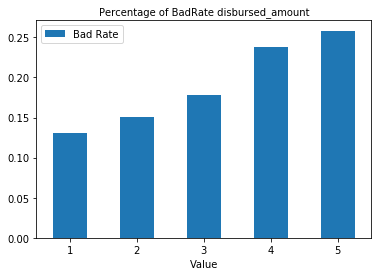

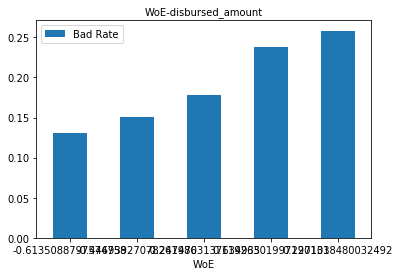

In [66]:
def disbursed_amount_bin(x):
    if x <= 30000:
        return 1
    elif x < 40000:
        return 2
    elif x < 50000:
        return 3
    elif x < 65000:
        return 4
    elif x >= 65000:
        return 5
    else :
        return 6
   
    
train['disbursed_amount_bin'] = train['disbursed_amount'].apply(disbursed_amount_bin)
test['disbursed_amount_bin'] = test['disbursed_amount'].apply(disbursed_amount_bin)
loan_test['disbursed_amount_bin'] = loan_test['disbursed_amount'].apply(disbursed_amount_bin)
iv_disbursed_amount, data_disbursed_amount = calc_iv(train, 'disbursed_amount_bin', 'loan_default')
data_disbursed_amount
    
print('IV -->',[('disbursed_amount',iv_disbursed_amount)])
Embarked_map = data_disbursed_amount.set_index('Value')['WoE'].to_dict()
train['disbursed_amount_WoE']=train['disbursed_amount_bin'].map(Embarked_map)

data_disbursed_amount.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate disbursed_amount",fontsize= 10)
data_disbursed_amount.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE-disbursed_amount",fontsize= 10)

gini_disbursed_amount =gini(np.array(data_disbursed_amount['WoE']),np.array(data_disbursed_amount['Bad Rate']))
print('gini_disbursed_amount-->',gini_disbursed_amount)
data_disbursed_amount

    

### Calculating WOE - ltv


IV --> [('ltv', 0.6293079750156606)]
Gini Coeff--> 0.6


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ltv_bin,1,16335,14069,2266,0.100209,0.138721,0.110253,0.064004,-0.543835,0.025152
1,ltv_bin,2,17868,14952,2916,0.109613,0.163197,0.117173,0.082364,-0.352510,0.012271
2,ltv_bin,3,23034,18604,4430,0.141304,0.192324,0.145793,0.125127,-0.152854,0.003159
3,ltv_bin,4,36293,28379,7914,0.222643,0.218059,0.222395,0.223534,0.005106,0.000006
4,ltv_bin,5,69480,51602,17878,0.426232,0.257311,0.404385,0.504971,0.222133,0.022343


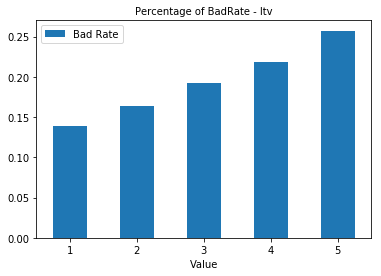

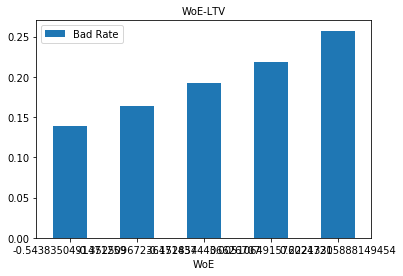

In [65]:

def func(x):
    if  10 <= x <= 58.99:
        return 1
    elif 59 <= x <= 66.99:
        return 2
    elif 67 <= x <=72.99 :
        return 3
    elif 73 <= x <=78.99 :
        return 4
    elif 79 <= x <=83.34 :
        return 5
    elif 83.35 <= x <=100 :
        return 5
    else :
        return 6
    
    
train['ltv_bin'] = train['ltv'].apply(func)
test['ltv_bin'] = test['ltv'].apply(func)
loan_test['ltv_bin'] = loan_test['ltv'].apply(func)
iv_ltv, data_ltv = calc_iv(train, 'ltv_bin', 'loan_default')
gini_ltv =gini(np.array(data_ltv['WoE']),np.array(data_ltv['Bad Rate']))
print('IV -->',[('ltv',iv_ltv)])

Embarked_map = data_ltv.set_index('Value')['WoE'].to_dict()
train['ltv_WoE']=train['ltv_bin'].map(Embarked_map)

print('Gini Coeff-->',gini_ltv)
data_ltv.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - ltv",fontsize= 10)
data_ltv.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE-LTV",fontsize= 10)

data_ltv
#print(train[['ltv_WoE','ltv']].head(6))

### Calculating WOE - Age


IV --> [('Age', 0.0861985158908584)]
Gini Coeff--> 0.5625


Text(0.5, 1.0, 'WoE-Age')

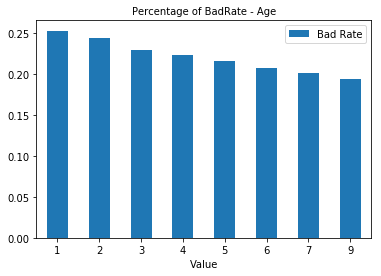

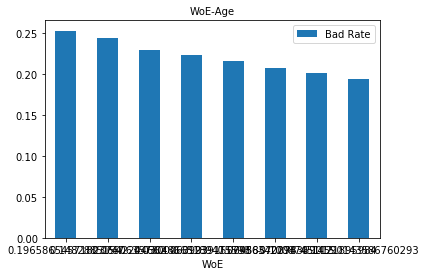

In [64]:
def func(x):
    if  18 <= x <= 22:
        return 1
    elif 23 <= x <= 24 :
        return 2
    elif 25 <= x <=27 :
        return 3
    elif 28 <= x <=31 :
        return 4
    elif 32 <= x <=36 :
        return 5
    elif 37 <= x <=43 :
        return 6
    elif 44 <= x <=70 :
        return 7
    elif 71 <= x <=100 :
        return 8
    else :
        return 9
    
    
train['Age_bin'] = train['Age'].apply(func)
test['Age_bin'] = test['Age'].apply(func)
loan_test['Age_bin'] = loan_test['Age'].apply(func)

iv_Age, data_Age = calc_iv(train, 'Age_bin', 'loan_default')
gini_Age=gini(np.array(data_Age['WoE']),np.array(data_Age['Bad Rate']))
print('IV -->',[('Age',iv_Age)])
print('Gini Coeff-->',gini_Age)

Embarked_map = data_Age.set_index('Value')['WoE'].to_dict()
train['Age_WoE']=train['Age_bin'].map(Embarked_map)

data_Age.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - Age",fontsize= 10)

data_Age.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE-Age",fontsize= 10)

### Calculating WOE - PERFORM_CNS.SCORE

IV --> [('PERFORM_CNS_SCORE', 0.04509878144635951)]
Gini Coeff--> 0.5833333333333334


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,PERFORM_CNS.SCORE_bin,1,2092,1456,636,0.012834,0.304015,0.011410,0.017964,0.453873,0.002975
1,PERFORM_CNS.SCORE_bin,2,2076,1499,577,0.012735,0.277938,0.011747,0.016298,0.327411,0.001490
2,PERFORM_CNS.SCORE_bin,3,3706,2751,955,0.022735,0.257690,0.021559,0.026974,0.224114,0.001214
3,PERFORM_CNS.SCORE_bin,4,12910,9776,3134,0.079198,0.242758,0.076611,0.088521,0.144502,0.001721
4,PERFORM_CNS.SCORE_bin,5,96943,74209,22734,0.594706,0.234509,0.581548,0.642131,0.099099,0.006004
5,PERFORM_CNS.SCORE_bin,6,45283,37915,7368,0.277793,0.162710,0.297126,0.208112,-0.356078,0.031696


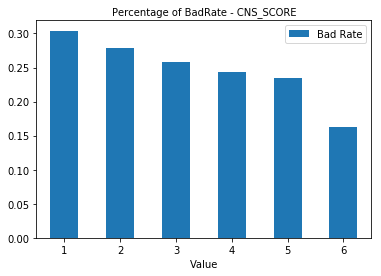

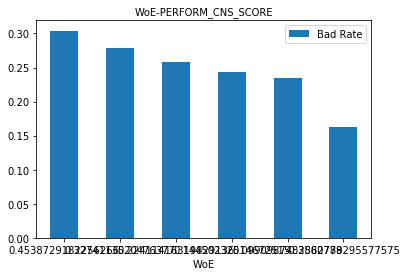

In [63]:

def func(x):
    if  x <= 300:
        return 5
    elif x <= 400:
        return 1
    elif x <= 450:
        return 2
    elif x <= 550:
        return 3
    elif x <= 650:
        return 4
    elif x <= 900:
        return 6
    else :
        return int((x-400)/50) +3
   
train['PERFORM_CNS.SCORE_bin'] = train['PERFORM_CNS.SCORE'].apply(func)
test['PERFORM_CNS.SCORE_bin'] = test['PERFORM_CNS.SCORE'].apply(func)
loan_test['PERFORM_CNS.SCORE_bin'] = loan_test['PERFORM_CNS.SCORE'].apply(func)
iv_PERFORM_CNS_SCORE, data_PERFORM_CNS_SCORE = calc_iv(train, 'PERFORM_CNS.SCORE_bin', 'loan_default')
gini_PERFORM_CNS_SCORE=gini(np.array(data_PERFORM_CNS_SCORE['WoE']),np.array(data_PERFORM_CNS_SCORE['Bad Rate']))
print('IV -->',[('PERFORM_CNS_SCORE',iv_PERFORM_CNS_SCORE)])
print('Gini Coeff-->',gini_PERFORM_CNS_SCORE)
Embarked_map = data_PERFORM_CNS_SCORE.set_index('Value')['WoE'].to_dict()
train['PERFORM_CNS_SCORE_WoE']=train['PERFORM_CNS.SCORE_bin'].map(Embarked_map)

data_PERFORM_CNS_SCORE.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - CNS_SCORE",fontsize= 10)

data_PERFORM_CNS_SCORE.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE-PERFORM_CNS_SCORE",fontsize= 10)

data_PERFORM_CNS_SCORE




### Calculating WOE - PRI.NO.OF.ACCTS

IV --> [('PRI_NO_OF_ACCTS', 0.12768821876126019)]
Gini Coeff--> 0.5833333333333334


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,PRI.NO.OF.ACCTS_bin,1,81857,62927,18930,0.502159,0.231257,0.493135,0.534685,0.080895,0.003361
1,PRI.NO.OF.ACCTS_bin,2,24333,18928,5405,0.149273,0.222126,0.148332,0.152666,0.028805,0.000125
2,PRI.NO.OF.ACCTS_bin,3,13878,10926,2952,0.085136,0.212711,0.085623,0.083380,-0.026540,0.000060
3,PRI.NO.OF.ACCTS_bin,4,9138,7255,1883,0.056058,0.206063,0.056855,0.053186,-0.066702,0.000245
4,PRI.NO.OF.ACCTS_bin,5,23007,18614,4393,0.141139,0.190942,0.145871,0.124082,-0.161779,0.003525
5,PRI.NO.OF.ACCTS_bin,6,10797,8956,1841,0.066235,0.170510,0.070185,0.052000,-0.299892,0.005454


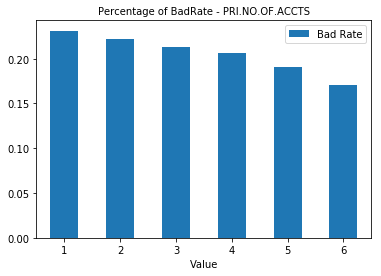

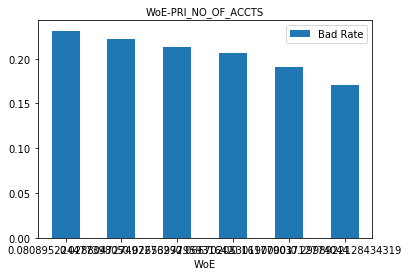

In [62]:

def func(x):
    if  x <= 0 :
        return 1
    elif  x<= 1  :
        return 2
    elif  x <= 2 :
        return 3
    elif  x <= 3 :
        return 4
    elif 4 <= x <=9 :
        return 5
    elif 10 <= x <=500 :
        return 6
    else :
        return 7
    
   
    
train['PRI.NO.OF.ACCTS_bin'] = train['PRI.NO.OF.ACCTS'].apply(func)
test['PRI.NO.OF.ACCTS_bin'] = test['PRI.NO.OF.ACCTS'].apply(func)
loan_test['PRI.NO.OF.ACCTS_bin'] = loan_test['PRI.NO.OF.ACCTS'].apply(func)

iv_PRI_NO_OF_ACCTS, data_PRI_NO_OF_ACCTS = calc_iv(train, 'PRI.NO.OF.ACCTS_bin', 'loan_default')
gini_PRI_NO_OF_ACCTS=gini(np.array(data_PRI_NO_OF_ACCTS['WoE']),np.array(data_PRI_NO_OF_ACCTS['Bad Rate']))
print('IV -->',[('PRI_NO_OF_ACCTS',iv_PRI_NO_OF_ACCTS)])
print('Gini Coeff-->',gini_PRI_NO_OF_ACCTS)
Embarked_map = data_PRI_NO_OF_ACCTS.set_index('Value')['WoE'].to_dict()
train['PRI_NO_OF_ACCTS_WoE']=train['PRI.NO.OF.ACCTS_bin'].map(Embarked_map)


data_PRI_NO_OF_ACCTS.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - PRI.NO.OF.ACCTS",fontsize= 10)
data_PRI_NO_OF_ACCTS.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE-PRI_NO_OF_ACCTS",fontsize= 10)


#print(train[['PRI_NO_OF_ACCTS_WoE','PRI.NO.OF.ACCTS']].head(6))
data_PRI_NO_OF_ACCTS


### Calculating WOE - PRI.CURRENT.BALANCE

IV --> [('PRI_CURRENT_BALANCE', 0.11220321149564125)]
Gini Coeff--> 0.625


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,PRI.CURRENT.BALANCE_bin,1,100626,77906,22720,0.617300,0.225787,0.610520,0.641735,0.049865,0.001557
1,PRI.CURRENT.BALANCE_bin,2,26835,20949,5886,0.164622,0.219340,0.164169,0.166252,0.012608,0.000026
2,PRI.CURRENT.BALANCE_bin,3,29488,23565,5923,0.180897,0.200861,0.184670,0.167297,-0.098797,0.001716
3,PRI.CURRENT.BALANCE_bin,4,6061,5186,875,0.037182,0.144366,0.040641,0.024715,-0.497371,0.007921


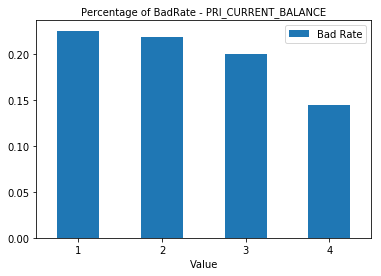

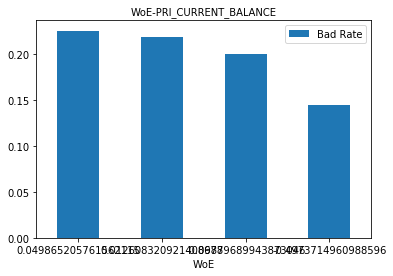

In [61]:
def func(x):
    if  -6678296 <= x <= 1040:
        return 1
    elif 1041 <= x <= 50840 :
        return 2
    elif 50841 <= x <=1097677 :
        return 3
    elif 1097678 <= x <=96524920 :
        return 4
    
    else :
        return 6
    
train['PRI.CURRENT.BALANCE_bin'] = train['PRI.CURRENT.BALANCE'].apply(func)
test['PRI.CURRENT.BALANCE_bin'] = test['PRI.CURRENT.BALANCE'].apply(func)
loan_test['PRI.CURRENT.BALANCE_bin'] = loan_test['PRI.CURRENT.BALANCE'].apply(func)
iv_PRI_CURRENT_BALANCE, data_PRI_CURRENT_BALANCE = calc_iv(train, 'PRI.CURRENT.BALANCE_bin', 'loan_default')
gini_PRI_CURRENT_BALANCE=gini(np.array(data_PRI_CURRENT_BALANCE['WoE']),np.array(data_PRI_CURRENT_BALANCE['Bad Rate']))
print('IV -->',[('PRI_CURRENT_BALANCE',iv_PRI_CURRENT_BALANCE)])
print('Gini Coeff-->',gini_PRI_CURRENT_BALANCE)

Embarked_map = data_PRI_CURRENT_BALANCE.set_index('Value')['WoE'].to_dict()
train['PRI_CURRENT_BALANCE_WoE']=train['PRI.CURRENT.BALANCE_bin'].map(Embarked_map)


data_PRI_CURRENT_BALANCE.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - PRI_CURRENT_BALANCE",fontsize= 10)
data_PRI_CURRENT_BALANCE.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE-PRI_CURRENT_BALANCE",fontsize= 10)
#print(train[['PRI_CURRENT_BALANCE_WoE','PRI.CURRENT.BALANCE']].head(6))

data_PRI_CURRENT_BALANCE


### Calculating WOE -AVERAGE.ACCT.AGE

IV --> [('AVERAGE_ACCT_AGE', 0.08297476077574123)]
Gini Coeff--> 0.625


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,AVERAGE.ACCT.AGE_bin,1,85081,65387,19694,0.521937,0.231474,0.512413,0.556265,0.082113,0.003601
1,AVERAGE.ACCT.AGE_bin,2,4498,3491,1007,0.027593,0.223877,0.027358,0.028443,0.038910,0.000042
2,AVERAGE.ACCT.AGE_bin,3,71952,57530,14422,0.441396,0.200439,0.450841,0.407355,-0.101429,0.004411
3,AVERAGE.ACCT.AGE_bin,4,1479,1198,281,0.009073,0.189993,0.009388,0.007937,-0.167932,0.000244


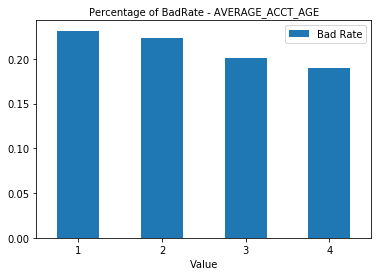

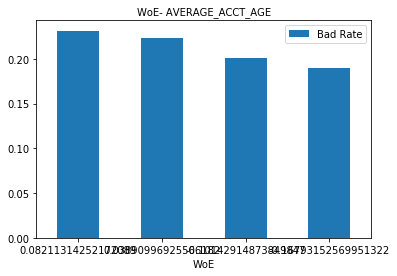

In [60]:


def func(x):
    if  0<= x <= 1:
        return 1
    elif 2<=x <= 3:
        return 2
    elif x <= 70 :
        return 3
    elif  x <=369 :
        return 4
    else :
        return 6
    
train['AVERAGE.ACCT.AGE_bin'] = train['AVERAGE.ACCT.AGE'].apply(func)
test['AVERAGE.ACCT.AGE_bin'] = test['AVERAGE.ACCT.AGE'].apply(func)
loan_test['AVERAGE.ACCT.AGE_bin'] = loan_test['AVERAGE.ACCT.AGE'].apply(func)
iv_AVERAGE_ACCT_AGE, data_AVERAGE_ACCT_AGE = calc_iv(train, 'AVERAGE.ACCT.AGE_bin', 'loan_default')
gini_AVERAGE_ACCT_AGE=gini(np.array(data_AVERAGE_ACCT_AGE['WoE']),np.array(data_AVERAGE_ACCT_AGE['Bad Rate']))
print('IV -->',[('AVERAGE_ACCT_AGE',iv_AVERAGE_ACCT_AGE)])
print('Gini Coeff-->',gini_AVERAGE_ACCT_AGE)

Embarked_map = data_AVERAGE_ACCT_AGE.set_index('Value')['WoE'].to_dict()
train['AVERAGE_ACCT_AGE_WoE']=train['AVERAGE.ACCT.AGE_bin'].map(Embarked_map)


data_AVERAGE_ACCT_AGE.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - AVERAGE_ACCT_AGE",fontsize= 10)
data_AVERAGE_ACCT_AGE.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE- AVERAGE_ACCT_AGE",fontsize= 10)

data_AVERAGE_ACCT_AGE


### Calculating WOE -NO.OF_INQUIRIES

IV --> [('NO_OF_INQUIRIES', 0.10765236053411872)]
Gini Coeff--> 0.625


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,NO.OF_INQUIRIES_bin,1,141132,111372,29760,0.865787,0.210866,0.872780,0.840583,-0.037588,0.001210
1,NO.OF_INQUIRIES_bin,2,15584,11756,3828,0.095601,0.245637,0.092127,0.108123,0.160101,0.002561
2,NO.OF_INQUIRIES_bin,3,5644,4072,1572,0.034624,0.278526,0.031911,0.044402,0.330337,0.004126
3,NO.OF_INQUIRIES_bin,4,650,406,244,0.003987,0.375385,0.003182,0.006892,0.772938,0.002868


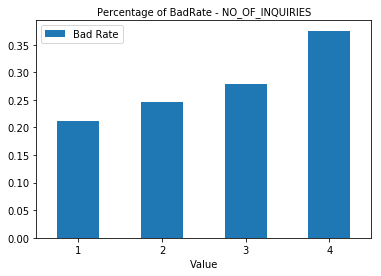

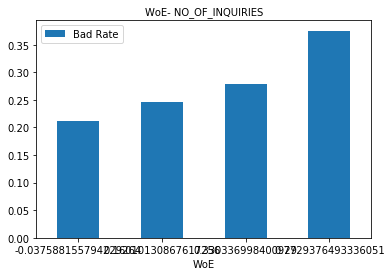

In [59]:
def func(x):
    
    if   x <=0 :
        return 1
    elif  x <= 1:
        return 2
    elif 2 <= x <=4 :
         return 3
    elif 5 <= x <=36 :
         return 4
    else :
        return 5
        
train['NO.OF_INQUIRIES_bin'] = train['NO.OF_INQUIRIES'].apply(func)
test['NO.OF_INQUIRIES_bin'] = test['NO.OF_INQUIRIES'].apply(func)
loan_test['NO.OF_INQUIRIES_bin'] = loan_test['NO.OF_INQUIRIES'].apply(func)
iv_NO_OF_INQUIRIES, data_NO_OF_INQUIRIES = calc_iv(train, 'NO.OF_INQUIRIES_bin', 'loan_default')
print('IV -->',[('NO_OF_INQUIRIES',iv_NO_OF_INQUIRIES)])
Embarked_map = data_NO_OF_INQUIRIES.set_index('Value')['WoE'].to_dict()
train['NO_OF_INQUIRIES_WoE']=train['NO.OF_INQUIRIES_bin'].map(Embarked_map)
gini_NO_OF_INQUIRIES=gini(np.array(data_NO_OF_INQUIRIES['WoE']),np.array(data_NO_OF_INQUIRIES['Bad Rate']))
print('Gini Coeff-->',gini_NO_OF_INQUIRIES)
data_NO_OF_INQUIRIES.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - NO_OF_INQUIRIES",fontsize= 10)

data_NO_OF_INQUIRIES.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE- NO_OF_INQUIRIES",fontsize= 10)


data_NO_OF_INQUIRIES



### Calculating WOE -PRIMARY.INSTAL.AMT

85262329
IV --> [('PRIMARY_INSTAL_AMT', 0.037940416317291226)]
Gini Coeff--> 0.5833333333333334


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,PRIMARY.INSTAL.AMT_bin,1,24425,18867,5558,0.149837,0.227554,0.147854,0.156988,0.059947,0.000548
1,PRIMARY.INSTAL.AMT_bin,2,111532,87113,24419,0.684203,0.218942,0.682672,0.689724,0.010278,0.000072
2,PRIMARY.INSTAL.AMT_bin,3,14010,11072,2938,0.085946,0.209707,0.086767,0.082985,-0.044568,0.000169
3,PRIMARY.INSTAL.AMT_bin,4,2885,2302,583,0.017698,0.202080,0.018040,0.016467,-0.091224,0.000143
4,PRIMARY.INSTAL.AMT_bin,5,6844,5473,1371,0.041985,0.200321,0.042890,0.038724,-0.102164,0.000426
5,PRIMARY.INSTAL.AMT_bin,6,3314,2779,535,0.020330,0.161436,0.021778,0.015111,-0.365457,0.002436


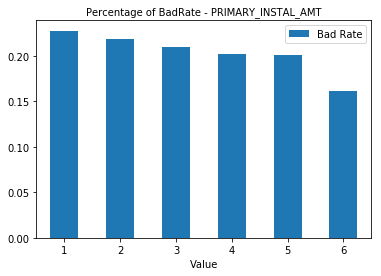

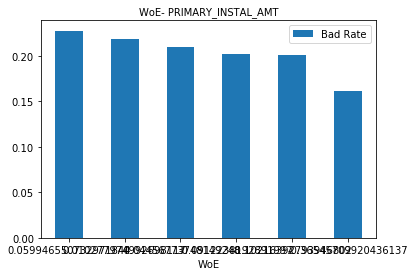

In [58]:
def func(x):
    #25642806
    
    if   x <=0 :
        return 2
    elif  x <= 5000:
        return 1
    elif  x <= 15000:
        return 3
    elif  x <=20000:
         return 4
    elif  x <=100000:
         return 5
    elif  x <=25642806:
         return 6
    else :
        print(x)
        return 7
        
train['PRIMARY.INSTAL.AMT_bin'] = train['PRIMARY.INSTAL.AMT'].apply(func)
test['PRIMARY.INSTAL.AMT_bin'] = test['PRIMARY.INSTAL.AMT'].apply(func)
loan_test['PRIMARY.INSTAL.AMT_bin'] = loan_test['PRIMARY.INSTAL.AMT'].apply(func)
iv_PRIMARY_INSTAL_AMT, data_PRIMARY_INSTAL_AMT = calc_iv(train, 'PRIMARY.INSTAL.AMT_bin', 'loan_default')
print('IV -->',[('PRIMARY_INSTAL_AMT',iv_PRIMARY_INSTAL_AMT)])
Embarked_map = data_PRIMARY_INSTAL_AMT.set_index('Value')['WoE'].to_dict()
train['PRIMARY_INSTAL_AMT_WoE']=train['PRIMARY.INSTAL.AMT_bin'].map(Embarked_map)
gini_PRIMARY_INSTAL_AMT=gini(np.array(data_PRIMARY_INSTAL_AMT['WoE']),np.array(data_PRIMARY_INSTAL_AMT['Bad Rate']))
print('Gini Coeff-->',gini_PRIMARY_INSTAL_AMT)
data_PRIMARY_INSTAL_AMT.plot.bar(x='Value', y='Bad Rate', rot=0)
plt.title("Percentage of BadRate - PRIMARY_INSTAL_AMT",fontsize= 10)

data_PRIMARY_INSTAL_AMT.plot.bar(x='WoE', y='Bad Rate', rot=0)
plt.title("WoE- PRIMARY_INSTAL_AMT",fontsize= 10)
data_PRIMARY_INSTAL_AMT



# Mapping WoE values to the predictors -TEST DATA SET 

In [26]:
Embarked_map = data_disbursed_amount.set_index('Value')['WoE'].to_dict()
test['disbursed_amount_WoE']=test['disbursed_amount_bin'].map(Embarked_map)

Embarked_map = data_ltv.set_index('Value')['WoE'].to_dict()
test['ltv_WoE']=test['ltv_bin'].map(Embarked_map)

Embarked_map = data_Age.set_index('Value')['WoE'].to_dict()
test['Age_WoE']=test['Age_bin'].map(Embarked_map)

Embarked_map = data_PERFORM_CNS_SCORE.set_index('Value')['WoE'].to_dict()
test['PERFORM_CNS_SCORE_WoE']=test['PERFORM_CNS.SCORE_bin'].map(Embarked_map)

Embarked_map = data_PRI_NO_OF_ACCTS.set_index('Value')['WoE'].to_dict()
test['PRI_NO_OF_ACCTS_WoE']=test['PRI.NO.OF.ACCTS_bin'].map(Embarked_map)


Embarked_map = data_PRI_CURRENT_BALANCE.set_index('Value')['WoE'].to_dict()
test['PRI_CURRENT_BALANCE_WoE']=test['PRI.CURRENT.BALANCE_bin'].map(Embarked_map)

Embarked_map = data_AVERAGE_ACCT_AGE.set_index('Value')['WoE'].to_dict()
test['AVERAGE_ACCT_AGE_WoE']=test['AVERAGE.ACCT.AGE_bin'].map(Embarked_map)

Embarked_map = data_NO_OF_INQUIRIES.set_index('Value')['WoE'].to_dict()
test['NO_OF_INQUIRIES_WoE']=test['NO.OF_INQUIRIES_bin'].map(Embarked_map)

Embarked_map = data_PRIMARY_INSTAL_AMT.set_index('Value')['WoE'].to_dict()
test['PRIMARY_INSTAL_AMT_WoE']=test['PRIMARY.INSTAL.AMT_bin'].map(Embarked_map)


# Mapping WoE values to the predictors -LOAN TEST DATA SET 

In [27]:
Embarked_map = data_disbursed_amount.set_index('Value')['WoE'].to_dict()
loan_test['disbursed_amount_WoE']=loan_test['disbursed_amount_bin'].map(Embarked_map)

Embarked_map = data_ltv.set_index('Value')['WoE'].to_dict()
loan_test['ltv_WoE']=loan_test['ltv_bin'].map(Embarked_map)

Embarked_map = data_Age.set_index('Value')['WoE'].to_dict()
loan_test['Age_WoE']=loan_test['Age_bin'].map(Embarked_map)


Embarked_map = data_PERFORM_CNS_SCORE.set_index('Value')['WoE'].to_dict()
loan_test['PERFORM_CNS_SCORE_WoE']=loan_test['PERFORM_CNS.SCORE_bin'].map(Embarked_map)


Embarked_map = data_PRI_NO_OF_ACCTS.set_index('Value')['WoE'].to_dict()
loan_test['PRI_NO_OF_ACCTS_WoE']=loan_test['PRI.NO.OF.ACCTS_bin'].map(Embarked_map)



Embarked_map = data_PRI_CURRENT_BALANCE.set_index('Value')['WoE'].to_dict()
loan_test['PRI_CURRENT_BALANCE_WoE']=loan_test['PRI.CURRENT.BALANCE_bin'].map(Embarked_map)


Embarked_map = data_AVERAGE_ACCT_AGE.set_index('Value')['WoE'].to_dict()
loan_test['AVERAGE_ACCT_AGE_WoE']=loan_test['AVERAGE.ACCT.AGE_bin'].map(Embarked_map)


Embarked_map = data_NO_OF_INQUIRIES.set_index('Value')['WoE'].to_dict()
loan_test['NO_OF_INQUIRIES_WoE']=loan_test['NO.OF_INQUIRIES_bin'].map(Embarked_map)

Embarked_map = data_PRIMARY_INSTAL_AMT.set_index('Value')['WoE'].to_dict()
loan_test['PRIMARY_INSTAL_AMT_WoE']=loan_test['PRIMARY.INSTAL.AMT_bin'].map(Embarked_map)


# Creating a new dataset train_woe from the Weight of Evidence values

In [29]:
train_woe = train[['disbursed_amount_WoE','ltv_WoE','Age_WoE','AVERAGE_ACCT_AGE_WoE','PERFORM_CNS_SCORE_WoE','PRIMARY_INSTAL_AMT_WoE','PRI_CURRENT_BALANCE_WoE',\
                 'PRI_NO_OF_ACCTS_WoE','NO_OF_INQUIRIES_WoE','loan_default']]




In [30]:
train_woe.head()

,disbursed_amount_WoE,ltv_WoE,Age_WoE,AVERAGE_ACCT_AGE_WoE,PERFORM_CNS_SCORE_WoE,PRIMARY_INSTAL_AMT_WoE,PRI_CURRENT_BALANCE_WoE,PRI_NO_OF_ACCTS_WoE,NO_OF_INQUIRIES_WoE,loan_default
0,-0.613509,-0.543835,0.065064,0.082113,0.099099,0.010278,0.049865,0.080895,-0.037588,0
1,-0.247470,0.005106,-0.064586,-0.101429,0.144502,-0.365457,-0.098797,-0.161779,-0.037588,0
2,0.119263,0.222133,-0.064586,0.082113,0.099099,0.010278,0.049865,0.080895,-0.037588,0
3,0.119263,0.222133,-0.100875,-0.101429,0.099099,-0.091224,-0.098797,-0.299892,-0.037588,0
4,-0.446939,-0.543835,-0.064586,0.082113,0.099099,0.010278,0.049865,0.080895,-0.037588,0


# Creating a new dataset test_woe from the Weight of Evidence values

In [31]:
test_woe = test[['disbursed_amount_WoE','ltv_WoE','Age_WoE','AVERAGE_ACCT_AGE_WoE','PERFORM_CNS_SCORE_WoE','PRIMARY_INSTAL_AMT_WoE','PRI_CURRENT_BALANCE_WoE',\
                 'PRI_NO_OF_ACCTS_WoE','NO_OF_INQUIRIES_WoE','loan_default']]

In [32]:
test_woe.head()

,disbursed_amount_WoE,ltv_WoE,Age_WoE,AVERAGE_ACCT_AGE_WoE,PERFORM_CNS_SCORE_WoE,PRIMARY_INSTAL_AMT_WoE,PRI_CURRENT_BALANCE_WoE,PRI_NO_OF_ACCTS_WoE,NO_OF_INQUIRIES_WoE,loan_default
0,0.119263,0.222133,-0.100875,0.082113,0.099099,0.010278,0.049865,0.080895,-0.037588,0
1,-0.247470,-0.352510,0.030487,-0.101429,0.144502,-0.044568,-0.098797,-0.026540,-0.037588,0
2,0.119263,-0.352510,-0.012392,-0.101429,0.099099,0.010278,0.049865,0.080895,-0.037588,0
3,0.119263,0.222133,0.065064,-0.101429,0.144502,-0.044568,-0.098797,-0.299892,0.160101,0
4,0.119263,0.222133,0.065064,-0.101429,-0.356078,0.059947,0.012608,-0.026540,0.160101,0


# Creating a new dataset loan_test_woe from the Weight of Evidence values

In [33]:
loan_test_woe = loan_test[['UniqueID','disbursed_amount_WoE','ltv_WoE','Age_WoE','AVERAGE_ACCT_AGE_WoE','PERFORM_CNS_SCORE_WoE','PRIMARY_INSTAL_AMT_WoE','PRI_CURRENT_BALANCE_WoE',\
                 'PRI_NO_OF_ACCTS_WoE','NO_OF_INQUIRIES_WoE']]

# exporting train_Woe and test_Woe to csv

In [34]:
train_woe.to_csv('train_woe.csv', index=False, header=True)
test_woe.to_csv('test_woe.csv', index=False, header=True)
loan_test_woe.to_csv('loan_test_woe.csv', index=False, header=True)

# Variable Deviation Index

In [35]:
import numpy as np

def calculate_VDI(expected, actual, buckettype='bins', buckets=10, axis=0):
    def VDI(expected_array, actual_array, buckets):
        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_VDI(e_perc, a_perc):
            '''Calculate the actual VDI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        VDI_value = np.sum(sub_VDI(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(VDI_value)

    if len(expected.shape) == 1:
        VDI_values = np.empty(len(expected.shape))
    else:
        VDI_values = np.empty(expected.shape[axis])

    for i in range(0, len(VDI_values)):
        if len(VDI_values) == 1:
            VDI_values = VDI(expected, actual, buckets)
        elif axis == 0:
            VDI_values[i] = VDI(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            VDI_values[i] = VDI(expected[i,:], actual[i,:], buckets)

    return(VDI_values)
VDI_disbursed_amount=calculate_VDI(test_woe['disbursed_amount_WoE'], train_woe['disbursed_amount_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_ltv=calculate_VDI(test_woe['ltv_WoE'], train_woe['ltv_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_Age=calculate_VDI(test_woe['Age_WoE'], train_woe['Age_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_PERFORM_CNS_SCORE=calculate_VDI(test_woe['PERFORM_CNS_SCORE_WoE'], train_woe['PERFORM_CNS_SCORE_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_PRI_NO_OF_ACCTS=calculate_VDI(test_woe['PRI_NO_OF_ACCTS_WoE'], train_woe['PRI_NO_OF_ACCTS_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_PRI_CURRENT_BALANCE=calculate_VDI(test_woe['PRI_CURRENT_BALANCE_WoE'], train_woe['PRI_CURRENT_BALANCE_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_AVERAGE_ACCT_AGE=calculate_VDI(test_woe['AVERAGE_ACCT_AGE_WoE'], train_woe['AVERAGE_ACCT_AGE_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_NO_OF_INQUIRIES=calculate_VDI(test_woe['NO_OF_INQUIRIES_WoE'], train_woe['NO_OF_INQUIRIES_WoE'], buckettype='bins', buckets=10, axis=1)
VDI_PRIMARY_INSTAL_AMT=calculate_VDI(test_woe['PRIMARY_INSTAL_AMT_WoE'], train_woe['PRIMARY_INSTAL_AMT_WoE'], buckettype='bins', buckets=10, axis=1)

In [39]:
test_VDI_disbursed_amount=calculate_VDI(loan_test_woe['disbursed_amount_WoE'], train_woe['disbursed_amount_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_ltv=calculate_VDI(loan_test_woe['ltv_WoE'], train_woe['ltv_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_Age=calculate_VDI(loan_test_woe['Age_WoE'], train_woe['Age_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_PERFORM_CNS_SCORE=calculate_VDI(loan_test_woe['PERFORM_CNS_SCORE_WoE'], train_woe['PERFORM_CNS_SCORE_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_PRI_NO_OF_ACCTS=calculate_VDI(loan_test_woe['PRI_NO_OF_ACCTS_WoE'], train_woe['PRI_NO_OF_ACCTS_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_PRI_CURRENT_BALANCE=calculate_VDI(loan_test_woe['PRI_CURRENT_BALANCE_WoE'], train_woe['PRI_CURRENT_BALANCE_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_AVERAGE_ACCT_AGE=calculate_VDI(loan_test_woe['AVERAGE_ACCT_AGE_WoE'], train_woe['AVERAGE_ACCT_AGE_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_NO_OF_INQUIRIES=calculate_VDI(loan_test_woe['NO_OF_INQUIRIES_WoE'], train_woe['NO_OF_INQUIRIES_WoE'], buckettype='bins', buckets=10, axis=1)
test_VDI_PRIMARY_INSTAL_AMT=calculate_VDI(loan_test_woe['PRIMARY_INSTAL_AMT_WoE'], train_woe['PRIMARY_INSTAL_AMT_WoE'], buckettype='bins', buckets=10, axis=1)

#  Stability metrics 

In [57]:
IV_values = [('ltv',iv_ltv,VDI_ltv,gini_ltv),
                ('disbursed_amount',iv_disbursed_amount,VDI_disbursed_amount,gini_disbursed_amount),
                ('PERFORM_CNS_SCORE',iv_PERFORM_CNS_SCORE,VDI_PERFORM_CNS_SCORE,gini_PERFORM_CNS_SCORE),
                ('PRI_NO_OF_ACCTS',iv_PRI_NO_OF_ACCTS,VDI_PRI_NO_OF_ACCTS,gini_PRI_NO_OF_ACCTS),
                ('PRI_CURRENT_BALANCE',iv_PRI_CURRENT_BALANCE,VDI_PRI_CURRENT_BALANCE,gini_PRI_CURRENT_BALANCE),
                ('NO_OF_INQUIRIES',iv_NO_OF_INQUIRIES,VDI_NO_OF_INQUIRIES,gini_NO_OF_INQUIRIES),
                ('Age',iv_Age,VDI_Age,gini_Age),
                ('AVERAGE_ACCT_AGE',iv_AVERAGE_ACCT_AGE,VDI_AVERAGE_ACCT_AGE,gini_AVERAGE_ACCT_AGE),
                ('PRIMARY_INSTAL_AMT',iv_PRIMARY_INSTAL_AMT,VDI_PRIMARY_INSTAL_AMT,gini_AVERAGE_ACCT_AGE) 
                               ]



IV_Values = pd.DataFrame(IV_values) 


Stability_metrics  = pd.DataFrame(IV_values, columns = ['Predictor' , 'IV_Values','VDI Values','GINI Index'])
Stability_metrics

,Predictor,IV_Values,VDI Values,GINI Index
0,ltv,0.062931,0.000064,0.600000
1,disbursed_amount,0.502287,0.000012,0.600000
2,PERFORM_CNS_SCORE,0.450988,0.000107,0.583333
3,PRI_NO_OF_ACCTS,0.127688,0.000097,0.583333
4,PRI_CURRENT_BALANCE,0.112203,0.000004,0.625000
5,NO_OF_INQUIRIES,0.107652,0.000190,0.625000
6,Age,0.086199,0.046196,0.562500
7,AVERAGE_ACCT_AGE,0.082975,0.000039,0.625000
8,PRIMARY_INSTAL_AMT,0.037940,0.000082,0.625000


### Observations

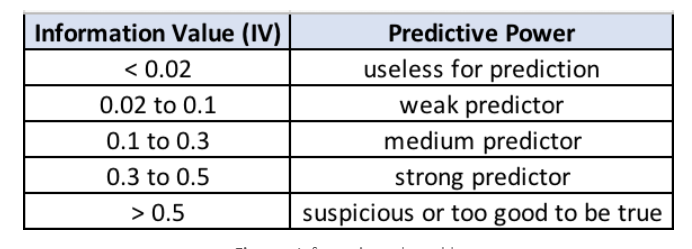

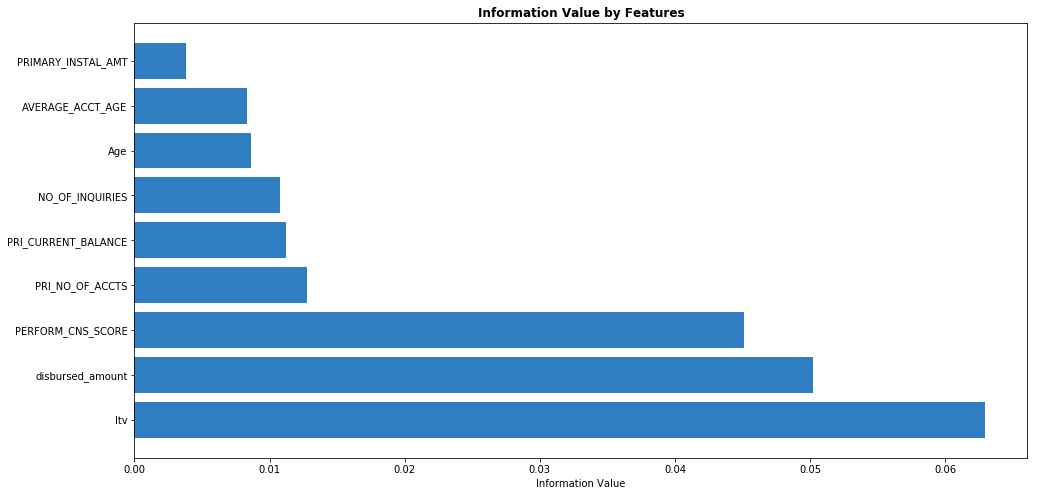

In [38]:

# Plot IV
plt.figure(figsize=(16,8))
plt.barh(Stability_metrics['Predictor'], Stability_metrics['IV_Values'], color = '#317DC2')
plt.xlabel('Information Value')
plt.title('Information Value by Features', fontweight="bold");
